In [193]:
!pytest

============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-7.0.1, pluggy-1.0.0
rootdir: /workspace
plugins: anyio-3.6.2
collected 17 items                                                             

tests/test_data.py ..                                                    [ 11%]
tests/models/test_metrics.py ...............                             [100%]

=============================== warnings summary ===============================
../usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/impl/api.py:22
  /usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/impl/api.py:22: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
    import imp

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html
======================== 17 passed, 1 warning in 4.10s =========================


In [192]:
!pytest -k 'test_df_to_dict'

============================= test session starts ==============================
platform linux -- Python 3.6.9, pytest-7.0.1, pluggy-1.0.0
rootdir: /workspace
plugins: anyio-3.6.2
collected 17 items / 16 deselected / 1 selected                                

tests/test_data.py .                                                     [100%]

=============================== warnings summary ===============================
../usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/impl/api.py:22
  /usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/impl/api.py:22: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
    import imp

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html
================= 1 passed, 16 deselected, 1 warning in 2.68s ==================


In [152]:
%load_ext autoreload
%autoreload 2

from functools import partial
import json
import os
from pathlib import Path
from PIL import Image


from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from pitch_geo import data
from pitch_geo.data import KeyPointsDataset
import vis_utils
import pitch_geo.models.metrics as metrics
from pitch_geo.models.metrics import NotVisiblePrecision

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 1
NUM_KEYPOINTS = 38 * 2  # 38 pairs each having x and y coordinates
DATA_FOLDER = Path('recruitment_task_pitch_geom')

In [228]:
df = pd.read_csv('recruitment_task_pitch_geom/df_keypoints.csv')
df = df[df['dataset'] == 'train']

key = df.query('kid == 38 and vis != 0')['image_path'].item()
idx1 = df.query(f'kid == 39 and image_path == "{key}"').index
idx2 = df.query(f'kid == 38 and image_path == "{key}"').index
df.loc[idx1, 'x'] = df.loc[idx2, 'x'].item()
df.loc[idx1, 'y'] = df.loc[idx2, 'y'].item()
df.loc[idx1, 'vis'] = df.loc[idx2, 'vis'].item()

df = df[df['kid'] != 38]

df['x'] = df['x'] / 1920
df['y'] = df['y'] / 1080

In [10]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        iaa.Fliplr(0.3),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

In [232]:
images_paths = df['image_path'].unique()

train_paths, test_paths = train_test_split(images_paths, test_size=0.15, random_state=42, shuffle=True)

train_df = df[df['image_path'].isin(train_paths)]
val_df = df[~df['image_path'].isin(train_paths)]

In [233]:
train_absolute_paths = [str(DATA_FOLDER / p) for p in  train_paths]

In [234]:
train_paths = tf.data.Dataset.from_tensor_slices(train_paths)

In [235]:
train_files = tf.data.Dataset.from_tensor_slices(train_absolute_paths)

In [13]:
def load_image(
    path, image_size, num_channels, interpolation, crop_to_aspect_ratio=False
):
    """Load an image from a path and resize it. Taken from https://github.com/keras-team/keras/blob/v2.10.0/keras/utils/image_dataset.py#L30. """
    img = tf.io.read_file(path)
    img = tf.image.decode_image(
        img, channels=num_channels, expand_animations=False
    )
    if crop_to_aspect_ratio:
        img = image_utils.smart_resize(
            img, image_size, interpolation=interpolation
        )
    else:
        img = tf.image.resize(img, image_size, method=interpolation)
    img.set_shape((image_size[0], image_size[1], num_channels))
    return img

In [236]:
train_images = train_files.map(
    partial(
        load_image, 
        image_size=(IMG_SIZE, IMG_SIZE),
        num_channels=3,
        interpolation='bilinear'        
    )
)
train_images = train_images.map(lambda x: x/255)

In [238]:
annotations_dict = data.df_to_dict(df)

def get_annotations(image_path):
    # image_path is supposed to be bytes object
    all_annotatios = annotations_dict[image_path.numpy().decode('utf-8')]
    
    # For tranining, we are only interested in keypoints coordinates:
    return all_annotatios['keypoints']

In [242]:
# Wrapping this inside tf.py_function s necessary. Otherwise TF throws AttributeError: 'Tensor' object has no attribute 'numpy'
train_labels = train_paths.map(lambda file_name: tf.py_function(get_annotations, [file_name], [tf.float16]))

In [218]:
import cv2

In [258]:
len(train_ds)

3248

In [243]:
img_path = next(iter(train_files))
keypoint = next(iter(train_labels))

img_path

<tf.Tensor: shape=(), dtype=string, numpy=b'recruitment_task_pitch_geom/images/train/a1401f391b8f64656723df05c36b24.jpg'>

In [244]:
keypoint[0].numpy()

array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.9443, 0.588 , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.0917, 0.6064, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.1719, 0.3564, 0.3062, 0.312 , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    ], dtype=float16)

In [247]:
train_ds = tf.data.Dataset.zip((train_images, train_labels))

In [248]:
img, keypoints = next(iter(train_ds))

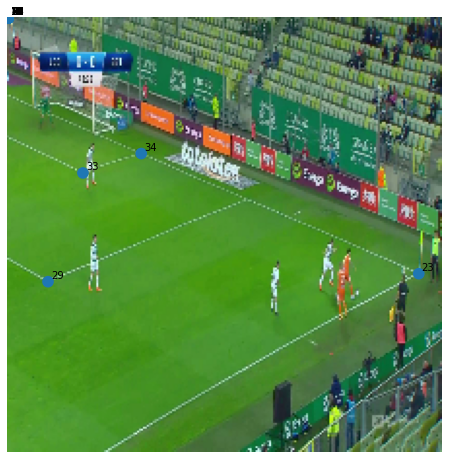

In [257]:
vis_utils.show_image_with_annotations(img.numpy(), keypoint[0].numpy(), dot_radius=3.0)

In [220]:
img = cv2.imread('recruitment_task_pitch_geom/images/train/a1401f391b8f64656723df05c36b24.jpg')

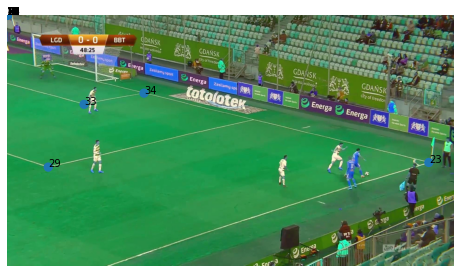

In [245]:
vis_utils.show_image_with_annotations(img, keypoint[0].numpy())

In [29]:
train_images.as_numpy_iterator().next().shape

(224, 224, 3)

In [110]:
df_view = df[df['image_path'] == 'images/train/00052c84fdad4ea0f1d43de9da804f.jpg']
df_view[['x', 'y']].apply(list, axis=1).sum()

[285,
 363,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 681,
 521,
 413,
 653,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 425,
 769,
 1820,
 932,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
annotations_dict = data.df_to_dict(df)

def get_annotations(image_path):
    # image_path is supposed to be bytes object
    all_annotatios = annotations_dict[image_path.numpy().decode('utf-8')]
    
    # For tranining, we are only interested in keypoints coordinates:
    return all_annotatios['keypoints']

In [285]:
images_paths = df['image_path'].unique()

train_paths, test_paths = train_test_split(images_paths, test_size=0.15, random_state=42, shuffle=True)

# train_df = df[df['image_path'].isin(train_paths)]
# val_df = df[~df['image_path'].isin(train_paths)]

train_absolute_paths = [str(DATA_FOLDER / p) for p in  train_paths]
train_paths = tf.data.Dataset.from_tensor_slices(train_paths)
train_files = tf.data.Dataset.from_tensor_slices(train_absolute_paths)

train_images = train_files.map(
    partial(
        load_image, 
        image_size=(IMG_SIZE, IMG_SIZE),
        num_channels=3,
        interpolation='bilinear'        
    )
)
train_images = train_images.map(lambda x: x/255)

# Wrapping this inside tf.py_function s necessary. Otherwise TF throws AttributeError: 'Tensor' object has no attribute 'numpy'
train_labels = train_paths.map(lambda file_name: tf.py_function(get_annotations, [file_name], [tf.float16]))

train_ds = tf.data.Dataset.zip((train_images, train_labels))

In [278]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [279]:
img, keypoints = next(iter(train_ds))

In [281]:
keypoints

<tf.Tensor: shape=(64,), dtype=float16, numpy=
array([0.04532, 0.2537 , 0.     , 0.     , 0.     , 0.0896 , 0.     ,
       0.     , 0.     , 0.0865 , 0.     , 0.7935 , 0.     , 0.     ,
       0.     , 0.1042 , 0.     , 0.326  , 0.     , 0.386  , 0.     ,
       0.0948 , 0.     , 0.     , 0.1224 , 0.     , 0.312  , 0.     ,
       0.     , 0.     , 0.     , 0.3694 , 0.     , 0.     , 0.     ,
       0.9556 , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.826  , 0.     , 0.     , 0.     , 0.     , 0.8276 , 0.     ,
       0.     , 0.1948 , 0.     , 0.     , 0.11304, 0.     , 0.     ,
       0.     , 0.     , 0.1292 , 0.     , 0.     , 0.3572 , 0.     ,
       0.4922 ], dtype=float16)>